<a href="https://www.kaggle.com/code/yousefroshdy/project-military-vehicles-ai-training?scriptVersionId=118905645" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
#from helper_functions import create_tensorboard_callback,plot_loss_curves

In [2]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [3]:
dataset = "../input/normal-vs-military-vehicles/dataset/"

***Create data fram for each image path with its label***

In [4]:
image_dir = Path(dataset)

filepaths = list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

In [5]:
image_df

,Filepath,Label
0,../input/normal-vs-military-vehicles/dataset/v...,millitary
1,../input/normal-vs-military-vehicles/dataset/v...,millitary
2,../input/normal-vs-military-vehicles/dataset/v...,millitary
3,../input/normal-vs-military-vehicles/dataset/v...,millitary
4,../input/normal-vs-military-vehicles/dataset/v...,millitary
...,...,...
17448,../input/normal-vs-military-vehicles/dataset/t...,other
17449,../input/normal-vs-military-vehicles/dataset/t...,other
17450,../input/normal-vs-military-vehicles/dataset/t...,other
17451,../input/normal-vs-military-vehicles/dataset/t...,other


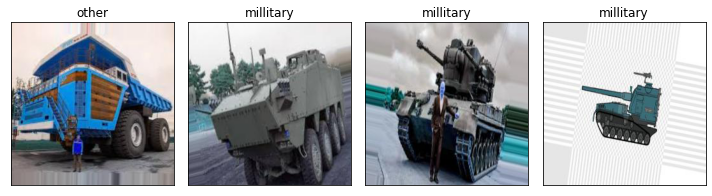

In [6]:
random_index = np.random.randint(0, len(image_df), 4)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [7]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [8]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [9]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 11170 validated image filenames belonging to 2 classes.
Found 2792 validated image filenames belonging to 2 classes.
Found 3491 validated image filenames belonging to 2 classes.


In [10]:
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

In [11]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

2023-02-12 03:01:08.979103: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [12]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [13]:
checkpoint_path = "shell_and_pebbles_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [14]:
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 5,
                               restore_best_weights = True)

In [15]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):

  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [16]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(2, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=25,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "military_vehicles_classification"),
        checkpoint_callback,
    ]
)

2023-02-12 03:01:10.339305: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-02-12 03:01:10.339533: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-02-12 03:01:10.340828: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Saving TensorBoard log files to: training_logs/military_vehicles_classification/20230212-030110


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2023-02-12 03:01:10.682007: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
  1/350 [..............................] - ETA: 18:55 - loss: 0.7988 - accuracy: 0.5000

2023-02-12 03:01:14.048291: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-02-12 03:01:14.048685: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/350 [..............................] - ETA: 2:04 - loss: 0.8482 - accuracy: 0.4531 

2023-02-12 03:01:14.331736: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-02-12 03:01:14.341925: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-02-12 03:01:14.356761: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: training_logs/military_vehicles_classification/20230212-030110/train/plugins/profile/2023_02_12_03_01_14

2023-02-12 03:01:14.359929: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to training_logs/military_vehicles_classification/20230212-030110/train/plugins/profile/2023_02_12_03_01_14/878e1a8c16b5.trace.json.gz
2023-02-12 03:01:14.382395: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: training_logs/military_vehicles_classification/20230212-030110/train/plugins/profile/2023_02_12_03_01_14

2023-02-12 03:01:14.384575: I tensorflow/core/profiler/rpc/client/save_profile.c

350/350 [==============================] - 130s 364ms/step - loss: 0.6263 - accuracy: 0.6568 - val_loss: 0.4126 - val_accuracy: 0.8571
Epoch 2/25
350/350 [==============================] - 121s 346ms/step - loss: 0.3938 - accuracy: 0.8382 - val_loss: 0.2883 - val_accuracy: 0.8961
Epoch 3/25
350/350 [==============================] - 124s 353ms/step - loss: 0.3065 - accuracy: 0.8751 - val_loss: 0.2399 - val_accuracy: 0.9144
Epoch 4/25
350/350 [==============================] - 123s 352ms/step - loss: 0.2646 - accuracy: 0.8967 - val_loss: 0.2142 - val_accuracy: 0.9223
Epoch 5/25
350/350 [==============================] - 126s 361ms/step - loss: 0.2374 - accuracy: 0.9092 - val_loss: 0.1997 - val_accuracy: 0.9259
Epoch 6/25
350/350 [==============================] - 125s 358ms/step - loss: 0.2188 - accuracy: 0.9154 - val_loss: 0.1894 - val_accuracy: 0.9302
Epoch 7/25
350/350 [==============================] - 124s 354ms/step - loss: 0.2059 - accuracy: 0.9218 - val_loss: 0.1826 - val_accura

In [17]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

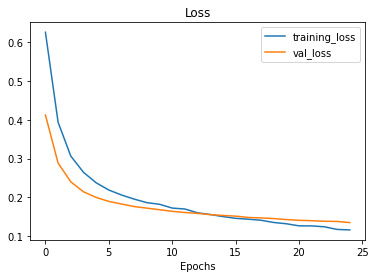

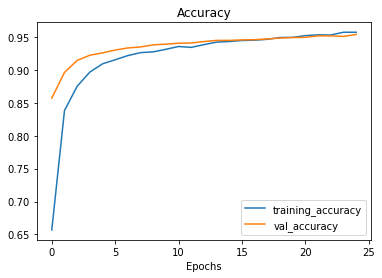

In [18]:
plot_loss_curves(history)

In [19]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['other', 'millitary', 'other', 'millitary', 'millitary']


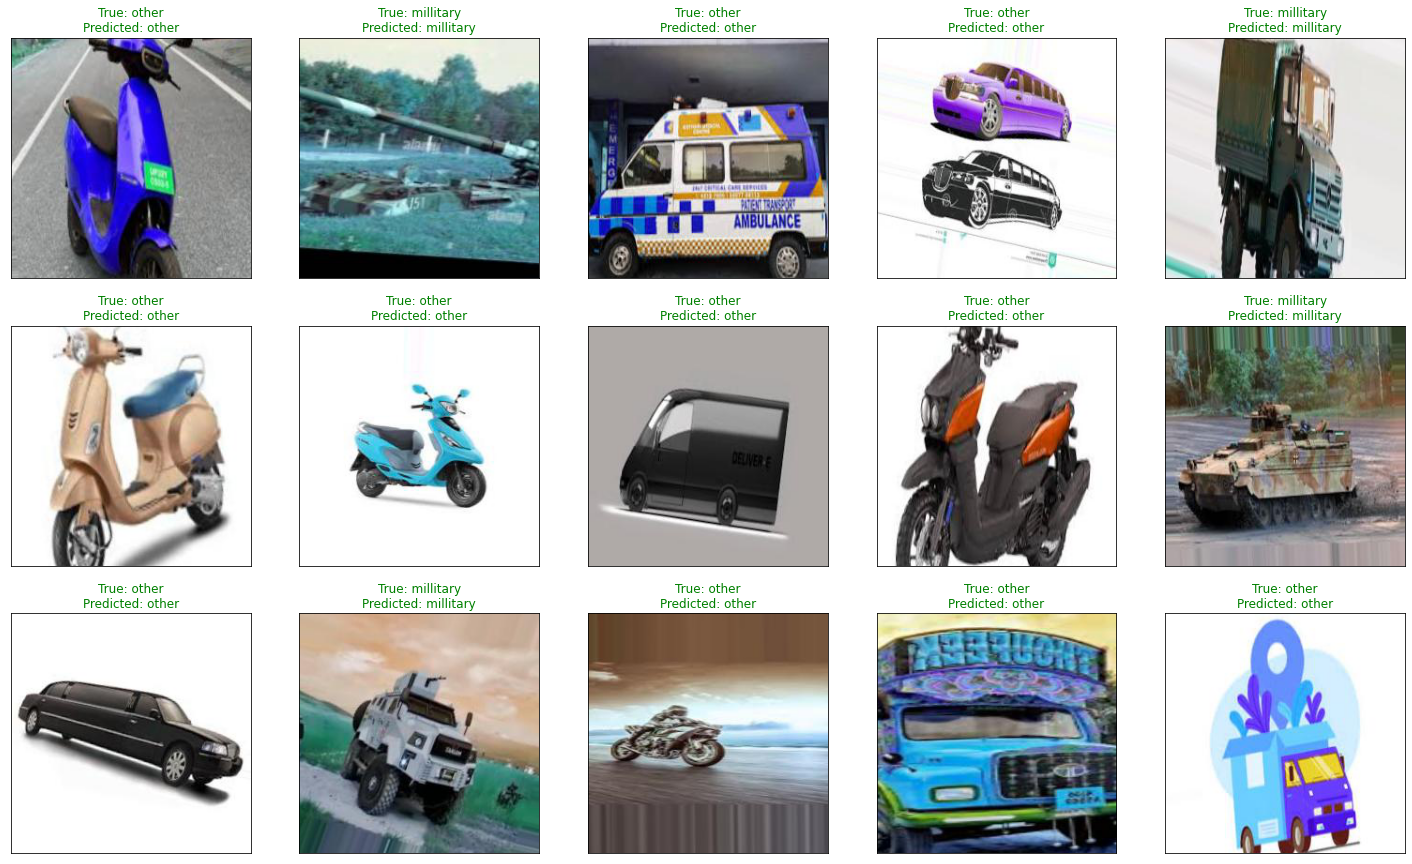

<Figure size 432x288 with 0 Axes>

In [20]:
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [22]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

   millitary       0.96      0.94      0.95      1620
       other       0.95      0.96      0.96      1871

    accuracy                           0.95      3491
   macro avg       0.95      0.95      0.95      3491
weighted avg       0.95      0.95      0.95      3491



In [23]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

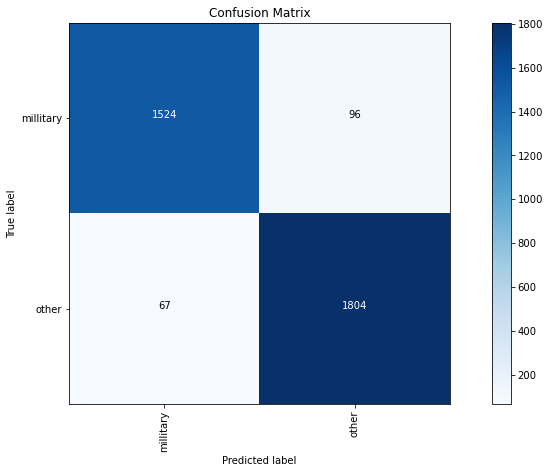

In [24]:
make_confusion_matrix(y_test, pred, list(labels.values()))